# Rozpoznawanie ras psów z wykorzystaniem biblioteki Keras
### Michał Foryt, Szczepan Gabiec, Paweł Wróblewski

<img src="meme2.jpg" style="width: 400px;">

Celem projektu jest stworzenie algorytmu służącego do rozpoznawaniu ras psów porzy wykorzystaniu biblioteki Keras, w oparciu o TensorFlow. Zbiór z którego korzystaliśmy pochodzi z jednego z konkursów zorganizowanych przez portal Kaggle i znajduje się pod tym linkiem: https://www.kaggle.com/c/dog-breed-identification. Z uwagi na jego rozmiar (~750MB) nie bedzie on dołączony bezpośrednio do kodu.  

W skład zbioru wchodzi około 10 tysięcy zdjęć, a wśród nich można wyróźnić 120 klas (ras psów). Pracując na tych danych, będziemy mogli stworzyć algorytm bazujący na głębokim uczeniu sieci neuronowych. W dużym uproszczeniu, zadaniem tego typu algorytmu jest rozpoznawanie obrazów podobnie, jak robi to umysł ludzki - "oglądając" ogromną pulę zdjęć z czasem rozpoznaje charakterystyczne cechy dla danego obiektu, przykładowo że rottweilera można poznać po tym, że jest duży i ma krótką, ciemną sierść, a york ma krótkie łapy i jest mocno owłosiony. Innymi słowy, algorytm najpierw zbiera dużą ilość danych, a następnie pozwala komputerowi zapoznać się z każdym z nich. Opierając się na dużych bazach danych i zauważając pojawiające się wzorce, komputery mogą rozpoznać obrazy i sformułować odpowiednie tagi i kategorie.

Formalnie można nakreślić następujacy przebieg metody:
- Na wejściu algorytm otrzymuje zbiór zawierający N obrazów, każdy z nich przypisany jest do jednej z K klas. 
- Następnie wykorzystuje się zbiór treningowy do szkolenia klasyfikatora tak, aby był on w stanie jak najepiej przyporządkować etykietę do zdjęcia.
- Na koniec ocenia się jakość klasyfikatora, prosząc go o przewidywanie etykiet dla nowego zestawu obrazów, których nigdy wcześniej nie widział, po czym porównamy prawdziwe etykiety tych obrazów z przewidywanymi przez klasyfikator.


## Konwolucyjne Sieci Neuronowe 
Konwolucyjne Sieci Neuronowe (ang. <i>CNN, Convolutional neural networks</i>, tłumaczone także jako <i>Splotowe Sieci Neuronowe</i>) w sprytny sposób redukują liczbę przyjmowanych parametrów. Zamiast działać na sieci, w której neurony są połączone każdy z każdym, podejście jakie prezentują CNN wykorzystują wielokrotnie te same parametry. Kluczem do sukcesu konwolucyjnych sieci jest fakt, że wychodza one z założenia, że wystarczy lokalne zrozumienie obrazu. Innymi słowy, algorytm skupia się na tym, by  stopniowo filtrować różne części danych uczących i wyostrzać ważne cechy w procesie dyskryminacji wykorzystanym do rozpoznawania lub klasyfikacji wzorców. W praktyce zaletą takiego podejścia jest posiadanie mniejszej liczby parametrów, co przekłada się na znaczne zmniejszenie czasu potrzebnego do wytrenowania modelu.

Rozważmy obraz o wymiarze 256 × 256 pikseli. Zamiast przetwarzać cały obraz naraz, CNN może skutecznie skanować go po kawałku - powiedzmy, patrząc na fragment o wymiarach 5 × 5. Taka ramka o wymiarach 5 × 5px przesuwa się wzdłuż obrazu (zwykle od lewej do prawej i od góry do dołu), jak pokazano na poniższym rysunku. 

<img src="cnn_concept.jpeg" style="width: 350px;">

Tempo przesuwania się takiej ramki nazywamy "długością kroku". Na przykład długość kroku 2 oznacza, że okno 5 × 5 przesuwa się o 2 piksele na raz, aż obejmie cały obraz. Taka ramka 5 x 5 pikseli przekłada się na macierz wag o wymiarze 5 x 5. 

Tego typu operacja ma miejsce w warstwie konwolucyjnej sieci neuronowej. Typowa CNN posiada wiele tego typu warste. Każda z nich zazwyczaj generuje wiele różnych splotów (ang. <i>convolutions</i>). Co za tym idzie, macierz wagowa takiego tensora (czyli obiektu matematycznego będącego uogólnieniem pojęcia wektora) ma wymiary 5 × 5 x n, gdzie n liczbą konwolucji (splotów).

Przykładowo, załóżmy że przepuszczamy rozważany obraz przez pojedynczą warstwę splotu jako macierz wagowa 5 x 5 x 64 z ramką 5 x 5. Co za ty idzie, taki model posiada 5 x 5 x64 = 1600 parametrów, podczas gdy pełna sieć dla obrazu 256 x 256px wymagałaby zastosowania 65 536 parametrów.

## Obróbka zbioru danych
Jak już wspomnielismy na początku, wykorzystamy zbiór danych dotyczący rozpoznawania ras psów, który wstępnie został już podzielony na zbiór treningowy i testowy. Nazwa każdego z obrazów jest też jednocześnie jego unikalnym id. Cały zestaw danych zawiera zdjęcia 120 ras, jednak dla urposzczenia modelu przyjmiemy założenie, że ograniczamy się jedynie do rozpoznawania 8 najpopularniejszych.

Dla porządku, wszystkie niezbędne importy zastosujemy poniżej. Dzięki temu uzyskamy większa czytelność oraz podcas tworzenia naszej funkcjonalności będziemy mieli pewność, że wszystkie niezbędne paczki zostały już ściągnięte.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import os
import matplotlib.pyplot as plt
from shutil import copyfile
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import cv2
import pandas as pd

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

Czytamy dane z pliku labels, które mapują id zdjęcia z jego opisem. na zbiorze treningowym. 

In [3]:
labels = pd.read_csv('labels.csv')
labels_dict = {i:j for i,j in zip(labels['id'],labels['breed'])}
classes = set(labels_dict.values())
images = [f for f in os.listdir('train')]

Tworzymy nowe katalogi, które zawierają zbiory zdjęć - treningowy i testowy. 

In [4]:
if not os.path.exists('training_images'):
        os.makedirs('training_images')

if not os.path.exists('validation_images'):
    os.makedirs('validation_images')

In [5]:
print(classes)

{'west_highland_white_terrier', 'chihuahua', 'australian_terrier', 'labrador_retriever', 'boxer', 'brittany_spaniel', 'entlebucher', 'basset', 'miniature_pinscher', 'schipperke', 'malinois', 'saluki', 'english_setter', 'lhasa', 'bull_mastiff', 'beagle', 'welsh_springer_spaniel', 'doberman', 'cocker_spaniel', 'greater_swiss_mountain_dog', 'collie', 'malamute', 'silky_terrier', 'leonberg', 'irish_wolfhound', 'boston_bull', 'bouvier_des_flandres', 'papillon', 'border_terrier', 'briard', 'standard_poodle', 'border_collie', 'pekinese', 'german_shepherd', 'appenzeller', 'walker_hound', 'komondor', 'dingo', 'saint_bernard', 'borzoi', 'whippet', 'gordon_setter', 'norwegian_elkhound', 'sealyham_terrier', 'giant_schnauzer', 'kelpie', 'clumber', 'bloodhound', 'english_springer', 'tibetan_terrier', 'japanese_spaniel', 'cairn', 'italian_greyhound', 'black-and-tan_coonhound', 'lakeland_terrier', 'groenendael', 'vizsla', 'tibetan_mastiff', 'blenheim_spaniel', 'pembroke', 'irish_terrier', 'kuvasz', 'm

Otwieramy folder z danymi treningowymi. Dla każdego z nich przygotowujemy katalogi, do których następnie będziemy zapisywać zdjęcia ras w osobne podkatalogi.

In [6]:
os.chdir('training_images')
for curClass in classes:    
    if not os.path.exists(curClass):
        os.makedirs(curClass)

 To samo robimy dla zbioru testowego. 

In [7]:
os.chdir('../validation_images')
for curClass in classes:    
    if not os.path.exists(curClass):
        os.makedirs(curClass)

Wracamy do głównego folderu. Po przygotowaniu odpowiednich katalogów możemy je wypełnić. Mamy około 20.5 tysięcy zdjęć, dzielimy je w proporcjach około 40:60 między zbiór treningowy i testowy - pierwsze 8 tysięcy zdjęć kopiujemy do odpowiednich katalogów w części uczącej, a pozostałe zdjęcia do przypisanych folderów w walidującej. 

In [8]:
os.chdir('..')
count = 0 
destination_directory = 'training_images/'
for item in images:
    if count >7999:
        destination_directory = 'validation_images/'
    filekey = os.path.splitext(item)[0]
    target_file = destination_directory+labels_dict[filekey]+'/'+item
    if not os.path.exists(target_file):
        copyfile('train/'+item, target_file)
    print(labels_dict[filekey])
    count +=1

chow
french_bulldog
redbone
chesapeake_bay_retriever
scottish_deerhound
redbone
basset
lakeland_terrier
shetland_sheepdog
cardigan
bluetick
tibetan_terrier
mexican_hairless
bedlington_terrier
groenendael
italian_greyhound
golden_retriever
italian_greyhound
komondor
lhasa
borzoi
sealyham_terrier
whippet
african_hunting_dog
samoyed
miniature_pinscher
pekinese
german_short-haired_pointer
afghan_hound
kuvasz
eskimo_dog
rottweiler
basenji
african_hunting_dog
airedale
australian_terrier
maltese_dog
great_pyrenees
greater_swiss_mountain_dog
toy_terrier
pug
bluetick
samoyed
italian_greyhound
samoyed
shih-tzu
miniature_pinscher
bouvier_des_flandres
afghan_hound
soft-coated_wheaten_terrier
newfoundland
wire-haired_fox_terrier
scotch_terrier
shih-tzu
lakeland_terrier
basenji
rottweiler
shih-tzu
chow
briard
basenji
whippet
japanese_spaniel
kuvasz
clumber
walker_hound
bernese_mountain_dog
bernese_mountain_dog
bernese_mountain_dog
irish_wolfhound
keeshond
kerry_blue_terrier
basenji
irish_water_spani

pomeranian
mexican_hairless
bouvier_des_flandres
bernese_mountain_dog
curly-coated_retriever
tibetan_mastiff
labrador_retriever
basenji
samoyed
keeshond
norwegian_elkhound
groenendael
dingo
eskimo_dog
sealyham_terrier
golden_retriever
irish_terrier
african_hunting_dog
english_foxhound
standard_poodle
briard
bloodhound
sealyham_terrier
miniature_schnauzer
cairn
staffordshire_bullterrier
silky_terrier
dandie_dinmont
blenheim_spaniel
groenendael
otterhound
keeshond
standard_schnauzer
basenji
boxer
curly-coated_retriever
kelpie
leonberg
boston_bull
shetland_sheepdog
dhole
dingo
briard
soft-coated_wheaten_terrier
golden_retriever
maltese_dog
eskimo_dog
doberman
bloodhound
samoyed
pomeranian
shih-tzu
bedlington_terrier
papillon
tibetan_terrier
papillon
newfoundland
greater_swiss_mountain_dog
papillon
golden_retriever
bedlington_terrier
yorkshire_terrier
pug
standard_poodle
bouvier_des_flandres
newfoundland
beagle
irish_wolfhound
black-and-tan_coonhound
whippet
sealyham_terrier
papillon
japan

dingo
basenji
great_dane
entlebucher
kelpie
papillon
lakeland_terrier
african_hunting_dog
scotch_terrier
cardigan
norwegian_elkhound
irish_wolfhound
ibizan_hound
komondor
whippet
basenji
african_hunting_dog
chow
australian_terrier
border_collie
australian_terrier
pekinese
leonberg
malinois
toy_terrier
shetland_sheepdog
great_dane
bluetick
golden_retriever
irish_setter
standard_schnauzer
otterhound
basenji
tibetan_terrier
shetland_sheepdog
great_pyrenees
norwich_terrier
toy_terrier
affenpinscher
dhole
toy_terrier
black-and-tan_coonhound
bull_mastiff
pomeranian
toy_poodle
airedale
papillon
bedlington_terrier
irish_wolfhound
eskimo_dog
kuvasz
sussex_spaniel
entlebucher
great_pyrenees
malamute
french_bulldog
pekinese
norwegian_elkhound
miniature_pinscher
affenpinscher
toy_terrier
irish_setter
basset
schipperke
briard
weimaraner
japanese_spaniel
lhasa
rhodesian_ridgeback
scottish_deerhound
border_collie
afghan_hound
french_bulldog
afghan_hound
chesapeake_bay_retriever
papillon
old_english_s

yorkshire_terrier
vizsla
basenji
pembroke
clumber
german_short-haired_pointer
doberman
basenji
sussex_spaniel
basenji
old_english_sheepdog
japanese_spaniel
cairn
samoyed
bedlington_terrier
japanese_spaniel
pomeranian
french_bulldog
west_highland_white_terrier
miniature_poodle
pembroke
bedlington_terrier
brittany_spaniel
lakeland_terrier
maltese_dog
great_dane
boston_bull
west_highland_white_terrier
kelpie
malamute
dingo
kerry_blue_terrier
shetland_sheepdog
toy_poodle
bedlington_terrier
standard_poodle
beagle
appenzeller
dandie_dinmont
great_pyrenees
dhole
bouvier_des_flandres
pomeranian
norwegian_elkhound
bloodhound
groenendael
shetland_sheepdog
saint_bernard
giant_schnauzer
borzoi
tibetan_mastiff
golden_retriever
german_shepherd
labrador_retriever
german_shepherd
border_collie
lakeland_terrier
briard
bloodhound
bedlington_terrier
boston_bull
cocker_spaniel
samoyed
rhodesian_ridgeback
entlebucher
saluki
australian_terrier
german_short-haired_pointer
bouvier_des_flandres
rhodesian_ridge

keeshond
italian_greyhound
wire-haired_fox_terrier
english_foxhound
whippet
tibetan_mastiff
giant_schnauzer
rhodesian_ridgeback
pug
doberman
standard_schnauzer
japanese_spaniel
norfolk_terrier
leonberg
sussex_spaniel
whippet
english_foxhound
groenendael
otterhound
siberian_husky
saluki
samoyed
appenzeller
bloodhound
malinois
tibetan_mastiff
chesapeake_bay_retriever
african_hunting_dog
groenendael
lakeland_terrier
toy_poodle
sealyham_terrier
bull_mastiff
whippet
leonberg
airedale
gordon_setter
miniature_pinscher
miniature_schnauzer
blenheim_spaniel
irish_water_spaniel
redbone
golden_retriever
japanese_spaniel
irish_setter
mexican_hairless
tibetan_mastiff
eskimo_dog
dingo
black-and-tan_coonhound
malamute
welsh_springer_spaniel
old_english_sheepdog
flat-coated_retriever
dingo
black-and-tan_coonhound
golden_retriever
yorkshire_terrier
vizsla
tibetan_mastiff
bluetick
brittany_spaniel
afghan_hound
boston_bull
australian_terrier
entlebucher
staffordshire_bullterrier
irish_wolfhound
papillon
i

schipperke
norwich_terrier
border_collie
beagle
soft-coated_wheaten_terrier
boxer
siberian_husky
afghan_hound
chihuahua
miniature_poodle
basset
west_highland_white_terrier
tibetan_mastiff
saluki
clumber
dingo
old_english_sheepdog
malamute
staffordshire_bullterrier
old_english_sheepdog
papillon
komondor
mexican_hairless
great_pyrenees
groenendael
bluetick
sealyham_terrier
welsh_springer_spaniel
greater_swiss_mountain_dog
borzoi
black-and-tan_coonhound
greater_swiss_mountain_dog
bernese_mountain_dog
yorkshire_terrier
siberian_husky
silky_terrier
bluetick
shih-tzu
borzoi
yorkshire_terrier
leonberg
staffordshire_bullterrier
papillon
shih-tzu
briard
australian_terrier
cardigan
miniature_schnauzer
groenendael
bluetick
chow
shih-tzu
giant_schnauzer
greater_swiss_mountain_dog
newfoundland
maltese_dog
maltese_dog
english_setter
black-and-tan_coonhound
irish_wolfhound
scottish_deerhound
ibizan_hound
black-and-tan_coonhound
saint_bernard
otterhound
irish_wolfhound
german_short-haired_pointer
blac

leonberg
collie
cairn
pug
shih-tzu
leonberg
entlebucher
leonberg
norfolk_terrier
norfolk_terrier
english_foxhound
african_hunting_dog
norwich_terrier
welsh_springer_spaniel
afghan_hound
german_shepherd
english_setter
japanese_spaniel
shih-tzu
doberman
golden_retriever
basenji
saint_bernard
samoyed
beagle
appenzeller
toy_terrier
staffordshire_bullterrier
afghan_hound
mexican_hairless
bluetick
greater_swiss_mountain_dog
borzoi
german_shepherd
miniature_poodle
airedale
boxer
standard_schnauzer
samoyed
basenji
keeshond
siberian_husky
sealyham_terrier
silky_terrier
malinois
weimaraner
sealyham_terrier
affenpinscher
boston_bull
appenzeller
labrador_retriever
miniature_pinscher
bouvier_des_flandres
saluki
keeshond
otterhound
boston_bull
sealyham_terrier
great_dane
irish_wolfhound
soft-coated_wheaten_terrier
dhole
english_foxhound
dandie_dinmont
boxer
toy_terrier
beagle
australian_terrier
cocker_spaniel
malinois
west_highland_white_terrier
komondor
toy_terrier
leonberg
italian_greyhound
labrad

cairn
black-and-tan_coonhound
bluetick
basenji
basset
sussex_spaniel
shetland_sheepdog
saint_bernard
english_foxhound
newfoundland
lhasa
basenji
sussex_spaniel
newfoundland
bedlington_terrier
shetland_sheepdog
komondor
norwegian_elkhound
cardigan
chihuahua
border_collie
toy_terrier
redbone
schipperke
black-and-tan_coonhound
affenpinscher
toy_poodle
sussex_spaniel
miniature_poodle
soft-coated_wheaten_terrier
brabancon_griffon
irish_water_spaniel
beagle
saluki
miniature_schnauzer
bull_mastiff
irish_water_spaniel
miniature_schnauzer
chow
german_shepherd
silky_terrier
maltese_dog
affenpinscher
scottish_deerhound
malamute
rottweiler
groenendael
pembroke
english_springer
golden_retriever
german_shepherd
silky_terrier
australian_terrier
great_dane
silky_terrier
chow
miniature_schnauzer
japanese_spaniel
ibizan_hound
toy_terrier
affenpinscher
basenji
lakeland_terrier
maltese_dog
labrador_retriever
great_dane
african_hunting_dog
labrador_retriever
blenheim_spaniel
leonberg
brittany_spaniel
welsh

kerry_blue_terrier
rhodesian_ridgeback
bloodhound
brabancon_griffon
english_setter
beagle
saint_bernard
rhodesian_ridgeback
saint_bernard
pomeranian
cardigan
shetland_sheepdog
schipperke
irish_terrier
dingo
greater_swiss_mountain_dog
groenendael
blenheim_spaniel
great_dane
pekinese
tibetan_terrier
scottish_deerhound
toy_poodle
eskimo_dog
welsh_springer_spaniel
whippet
bloodhound
miniature_poodle
vizsla
dingo
welsh_springer_spaniel
bernese_mountain_dog
maltese_dog
tibetan_terrier
basset
greater_swiss_mountain_dog
appenzeller
malinois
bedlington_terrier
afghan_hound
sussex_spaniel
sealyham_terrier
chow
miniature_poodle
dandie_dinmont
great_pyrenees
old_english_sheepdog
tibetan_mastiff
cocker_spaniel
boston_bull
newfoundland
wire-haired_fox_terrier
west_highland_white_terrier
komondor
cardigan
sussex_spaniel
gordon_setter
brabancon_griffon
boston_bull
old_english_sheepdog
norwegian_elkhound
siberian_husky
italian_greyhound
toy_poodle
english_foxhound
saint_bernard
newfoundland
old_english

## Image Augmentation
Image augmentation to technika polegająca na przekształcaniu oryginalnego obrazu tak, by uzyskać nowe dane testowe. Przykładowo dzieje się to poprzez dodanie szumu albo lustrzane odbicie. Dzięki temu możemy uzyskć więcej zdjęć testowych. W Pythonie, służy do tego klasa ImageDataGenerator, która ustawia parametry takie jak rotacja obrazu przybliżenie czy znieształcenie. Wykorzystamy ją do wygenerowania setek wariacji jednego ze zdjęć.   

In [9]:
datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.2,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('training_images/afghan_hound/0d5a88f0ab2db8d34b533c69768135e8.jpg') 
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0

if not os.path.exists('preview'):
        os.makedirs('preview')

for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='dog_breed', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # W przeciwnym pzypadku generator będzie działać w nieskonczoność

## Implementing Convolution Neural Network

In [10]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
#check class_mode in keras documentation https://keras.io/preprocessing/image/
training_set = train_datagen.flow_from_directory(
        'training_images',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'validation_images',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

Found 8000 images belonging to 120 classes.
Found 2222 images belonging to 120 classes.


In [11]:
from tensorflow.keras.layers import Dropout
clf = Sequential()
#Convolution
#32 is number of kernals of 3x3, we can use 64 128 256 etc in next layers
#input shape can be 128, 256 later
clf.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation='relu'))
#Max Pooling size reduces divided by 2
clf.add(MaxPooling2D(pool_size=(2,2)))      


#clf.add(Dropout(0.5))

clf.add(Conv2D(32,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
#clf.add(Dropout(0.25))

clf.add(Conv2D(64, (3, 3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2, 2)))
#clf.add(Dropout(0.10))
#Flattening
clf.add(Flatten())
        
#Adding An ANN
#lets take 128 hidden nodes in hidden layer
#clf.add(Dense(units=128,activation='relu'))
clf.add(Dense(units=64, activation='relu'))
clf.add(Dropout(0.5))
clf.add(Dense(units=120,activation='softmax'))
#stochastic gradient descent -Adam -optimizer
#loss func categorical cross entropy
#metrics = accuracy
clf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
early_stopping_monitor=EarlyStopping(patience=6)

In [13]:
hist=clf.fit_generator(
        training_set,
        steps_per_epoch=400,
        epochs=50,
        validation_data=test_set,
        validation_steps=2222,
        callbacks=[early_stopping_monitor])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
400/400 [==============================] - 649s 2s/step - loss: 4.7893 - accuracy: 0.0088 - val_loss: 4.7851 - val_accuracy: 0.0067
Epoch 2/50
400/400 [==============================] - 636s 2s/step - loss: 4.7841 - accuracy: 0.0099 - val_loss: 4.7833 - val_accuracy: 0.0094
Epoch 3/50
400/400 [==============================] - 633s 2s/step - loss: 4.7817 - accuracy: 0.0121 - val_loss: 4.7826 - val_accuracy: 0.0096
Epoch 4/50
400/400 [==============================] - 632s 2s/step - loss: 4.7797 - accuracy: 0.0122 - val_loss: 4.7817 - val_accuracy: 0.0093
Epoch 5/50
400/400 [==============================] - 635s 2s/step - loss: 4.7720 - accuracy: 0.0134 - val_loss: 4.7456 - val_accuracy: 0.0181
Epoch 6/50
400/400 [==============================] - 632s 2s/step - loss: 4.6954 - accuracy: 0.0186 - val_loss: 4.6435 - val_accuracy: 0.0202
Epoch 7/50
400/400 [==============================] - 635s 2s/step

In [14]:
test_set = []
test_set_ids = []
for curImage in os.listdir('test'):
    test_set_ids.append(os.path.splitext(curImage)[0])
    #print(os.path.splitext(curImage)[0])
    curImage = cv2.imread('test/'+curImage)
    test_set.append(cv2.resize(curImage,(128, 128)))

In [15]:
test_set = np.array(test_set, np.float32)/255.0

In [16]:
predictions = clf.predict(test_set)

In [17]:
predictions[0].shape

(120,)

In [18]:
training_set.class_indices

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [19]:
classes= {index:breed for breed,index in training_set.class_indices.items()}
column_names = [classes[i] for i in range(120)]
column_names

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [20]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = column_names
predictions_df.insert(0,'id', test_set_ids)
#predictions_df.index = test_set_ids
predictions_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,264833ebf9f2bf8b07651f72916f8c75,2.900902e-06,0.000585,2.635731e-04,0.000003,0.008480,2.396924e-02,0.000012,0.001588,0.004917,...,0.000024,0.002424,9.648097e-09,0.001832,0.000003,0.000593,0.000934,0.002654,0.000977,0.000194
1,ae2b2271318cc84364931ada1c75b295,3.118195e-08,0.000548,2.400944e-07,0.000064,0.000838,1.210372e-07,0.000112,0.000060,0.000050,...,0.012740,0.000033,2.333891e-06,0.000045,0.000117,0.000248,0.049741,0.000582,0.009058,0.001150
2,35d9bcc10f2762ed900f7a2c48d37c15,2.957512e-02,0.005290,1.424895e-02,0.002951,0.007598,1.216978e-02,0.003568,0.002224,0.003152,...,0.002641,0.009410,4.305375e-04,0.001887,0.005470,0.000624,0.000040,0.002772,0.001082,0.006715
3,66fabb7f526d842a06829a770b959b9d,9.456184e-03,0.015199,1.570331e-02,0.011085,0.010871,1.150277e-02,0.016441,0.008038,0.006736,...,0.009466,0.008155,2.444517e-03,0.005624,0.010407,0.003308,0.002661,0.008435,0.002573,0.011051
4,cf5b51fe08e3337217fca120a03ac993,7.939941e-05,0.010529,1.408992e-05,0.001937,0.001259,1.263514e-03,0.000305,0.001249,0.000376,...,0.000523,0.053644,4.942866e-06,0.007077,0.000005,0.000185,0.001201,0.007687,0.001589,0.000326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,5dac8f13467994de6ba778df1cdba3fd,3.309999e-03,0.011766,1.795336e-02,0.001856,0.027702,1.801897e-02,0.003710,0.004656,0.003883,...,0.000718,0.010027,5.682728e-05,0.001690,0.000190,0.000176,0.000181,0.005964,0.000412,0.002290
10353,4064e9fe3249051177c27d4d505c1d83,2.716383e-04,0.014683,1.234097e-03,0.004973,0.011745,3.825237e-04,0.003149,0.004777,0.002187,...,0.019434,0.002041,1.721084e-03,0.002987,0.011402,0.003453,0.037872,0.012053,0.010689,0.019354
10354,a9fa08dfaec85e98387911dd4364ce79,6.071250e-03,0.028392,2.969357e-03,0.024324,0.011933,8.339260e-03,0.008715,0.004898,0.002826,...,0.003989,0.026187,3.877653e-04,0.002575,0.000342,0.000565,0.001270,0.007379,0.001166,0.003513
10355,3be602e5b58c0274b72ad5322d3c8601,9.403349e-05,0.009794,3.040212e-04,0.012306,0.007019,2.382724e-05,0.009064,0.000755,0.000532,...,0.030369,0.000712,6.964786e-04,0.002369,0.011413,0.001848,0.017301,0.009824,0.010491,0.019731


In [21]:
predictions_df.to_csv('interim_submission.csv',sep=",")

## Graph representation of validation loss vs number of epochs

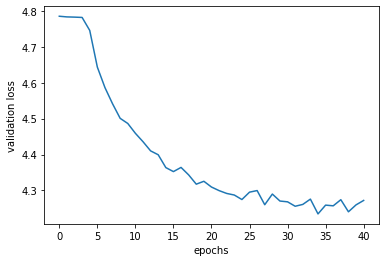

In [22]:
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.show()

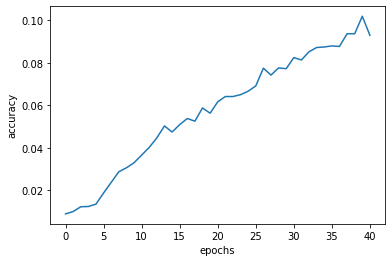

In [25]:
plt.plot(hist.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

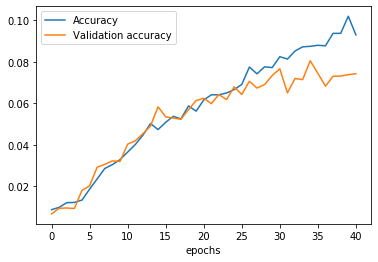

In [27]:
plt.plot(hist.history['accuracy'],label="Accuracy")
plt.plot(hist.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.xlabel('epochs')
plt.show()

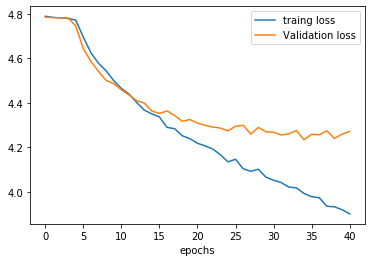

In [28]:
plt.plot(hist.history['loss'],label="traing loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.show()

## Observations